In [1]:
# Imports


import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import math
import warnings
import seaborn as sns
import os
import shutil
import datetime

# Suppress specific warnings (in this case, FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sktime.clustering.k_medoids import TimeSeriesKMedoids
from scipy.fftpack import fft, fftfreq
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.clustering import KShape
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from tqdm.notebook import tqdm


In [3]:
def calculate_mape(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred) * 100

In [5]:
NUM_CLUSTERS = 4

all_data_df = pd.DataFrame()
clustered_customers = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'../dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'../dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'../dataset/cluster_{i}/test.parquet'),
    ], axis=1).T.sort_index()
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    clustered_customers.append(list(df.columns))
    all_data_df  = pd.concat([all_data_df, df], axis=1)

In [7]:
customers = ['MT_091', 'MT_100', 'MT_101', 'MT_104', 'MT_137', 'MT_139', 'MT_145', 'MT_147', 'MT_166', 'MT_168', 'MT_175', 'MT_180', 'MT_182', 'MT_190', 'MT_193', 'MT_194', 'MT_195', 'MT_200', 'MT_204', 'MT_210', 'MT_212', 'MT_213', 'MT_215', 'MT_216', 'MT_218', 'MT_220', 'MT_222', 'MT_225', 'MT_227', 'MT_232', 'MT_233', 'MT_234', 'MT_237', 'MT_238', 'MT_239', 'MT_242', 'MT_243', 'MT_247', 'MT_248', 'MT_250', 'MT_251', 'MT_252', 'MT_253', 'MT_254', 'MT_256', 'MT_257', 'MT_258', 'MT_259', 'MT_261', 'MT_264', 'MT_266', 'MT_269', 'MT_271', 'MT_273', 'MT_274', 'MT_277', 'MT_278', 'MT_280', 'MT_282', 'MT_283', 'MT_285', 'MT_287', 'MT_294', 'MT_296', 'MT_298', 'MT_300', 'MT_301', 'MT_303', 'MT_304', 'MT_306', 'MT_307', 'MT_309', 'MT_310', 'MT_311', 'MT_313', 'MT_314', 'MT_315', 'MT_317', 'MT_318', 'MT_319', 'MT_320', 'MT_321', 'MT_323', 'MT_324', 'MT_326', 'MT_327', 'MT_328', 'MT_329', 'MT_341', 'MT_345', 'MT_350', 'MT_352', 'MT_353', 'MT_356', 'MT_357', 'MT_360', 'MT_363', 'MT_364', 'MT_365', 'MT_369', 'MT_098', 'MT_099', 'MT_103', 'MT_105', 'MT_126', 'MT_154', 'MT_172', 'MT_189', 'MT_191', 'MT_192', 'MT_197', 'MT_198', 'MT_199', 'MT_201', 'MT_202', 'MT_203', 'MT_205', 'MT_206', 'MT_207', 'MT_209', 'MT_211', 'MT_214', 'MT_217', 'MT_221', 'MT_229', 'MT_230', 'MT_231', 'MT_236', 'MT_240', 'MT_244', 'MT_245', 'MT_246', 'MT_263', 'MT_275', 'MT_286', 'MT_293', 'MT_297', 'MT_312', 'MT_325', 'MT_330', 'MT_335', 'MT_338', 'MT_339', 'MT_340', 'MT_343', 'MT_344', 'MT_346', 'MT_349', 'MT_351', 'MT_354', 'MT_355', 'MT_358', 'MT_361', 'MT_068', 'MT_150', 'MT_171', 'MT_260', 'MT_262', 'MT_265', 'MT_268', 'MT_270', 'MT_281', 'MT_284', 'MT_292', 'MT_295', 'MT_299', 'MT_331', 'MT_342', 'MT_148', 'MT_149', 'MT_161', 'MT_196', 'MT_228', 'MT_267', 'MT_276', 'MT_359', 'MT_208', 'MT_279', 'MT_362', 'MT_119', 'MT_007', 'MT_102', 'MT_272', 'MT_174', 'MT_241', 'MT_226', 'MT_141', 'MT_138', 'MT_316', 'MT_142', 'MT_143', 'MT_125', 'MT_118', 'MT_086', 'MT_057', 'MT_002', 'MT_051', 'MT_176', 'MT_169', 'MT_073', 'MT_079', 'MT_082', 'MT_004', 'MT_008', 'MT_017', 'MT_020', 'MT_027', 'MT_028', 'MT_031', 'MT_034', 'MT_037', 'MT_042', 'MT_043', 'MT_044', 'MT_048', 'MT_050', 'MT_053', 'MT_054', 'MT_056', 'MT_060', 'MT_062', 'MT_065', 'MT_069', 'MT_071', 'MT_072', 'MT_074', 'MT_075', 'MT_076', 'MT_080', 'MT_081', 'MT_083', 'MT_085', 'MT_088', 'MT_089', 'MT_334', 'MT_011', 'MT_016', 'MT_019', 'MT_021', 'MT_026', 'MT_035', 'MT_046', 'MT_049', 'MT_058', 'MT_061', 'MT_063', 'MT_070', 'MT_018', 'MT_059', 'MT_087', 'MT_005', 'MT_006', 'MT_025', 'MT_052', 'MT_067', 'MT_333', 'MT_336', 'MT_235', 'MT_291', 'MT_014', 'MT_077', 'MT_095', 'MT_096', 'MT_164']


In [9]:
explanatory_variables_df = pd.read_parquet('../dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')

In [11]:
combined_df = pd.concat([all_data_df, explanatory_variables_df], axis=1)
combined_df = combined_df.reset_index().rename(columns={'date': 'ds'})
combined_df = combined_df.dropna()

numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
numeric_data = combined_df[numeric_cols]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)
combined_df = pd.concat([combined_df.drop(numeric_cols, axis=1).reset_index(drop=True), scaled_df], axis=1)

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

cutoff_date = pd.to_datetime('2014-01-01')

mape_values = dict()
predictions = dict()

for customer in customers:
    customer_df = combined_df.rename(columns={customer: 'y'})
    train_df = customer_df[customer_df.ds < cutoff_date]
    test_df = customer_df[customer_df.ds >= cutoff_date]
    
    # Exponential Smoothing model - Holt-Winters (additive or multiplicative depending on your data)
    model = ExponentialSmoothing(
        train_df['y'],
        trend='add',      # or 'mul' for multiplicative trend
        seasonal='add',   # or 'mul' for multiplicative seasonality, or None
        seasonal_periods=365# set this to your seasonality, e.g., 12 for monthly seasonality
    )

    fitted_model = model.fit()
    
    # Forecasting for the length of the test set
    forecast = fitted_model.forecast(steps=len(test_df))
    
    mape = calculate_mape(test_df['y'], forecast)
    mape_values[customer] = mape
    
    forecast_df = test_df.copy()
    forecast_df['yhat'] = forecast.values
    predictions[customer] = forecast_df

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed

Minimum MAPE for Cluster 1: 128.40526984083485


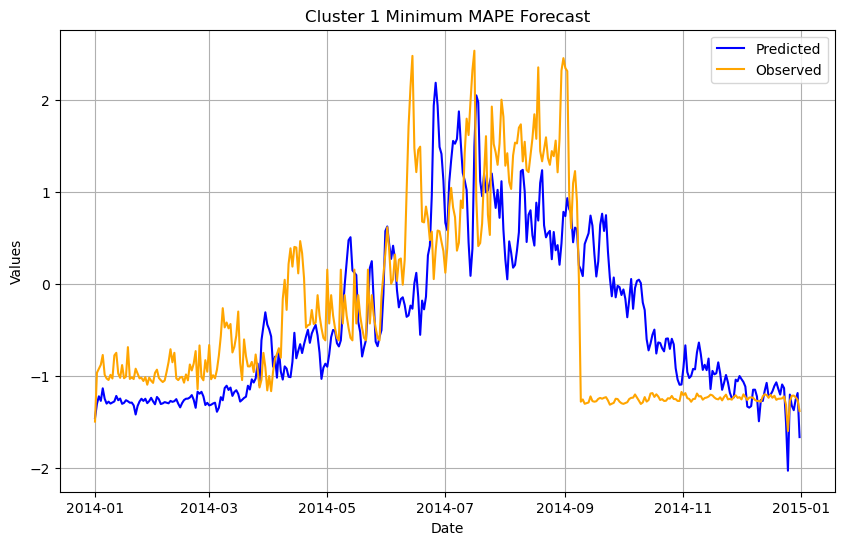

Maximum MAPE for Cluster 1: 90582.97792261725


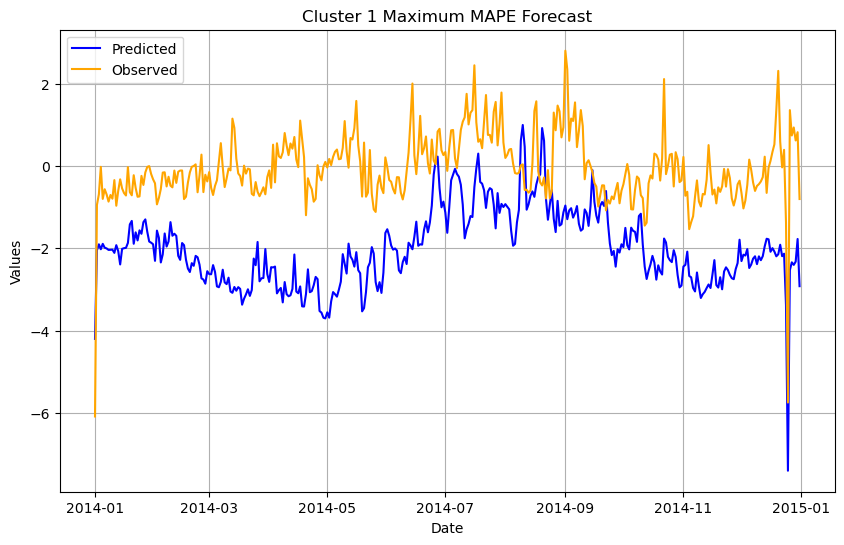

Minimum MAPE for Cluster 2: 85.41653570464607


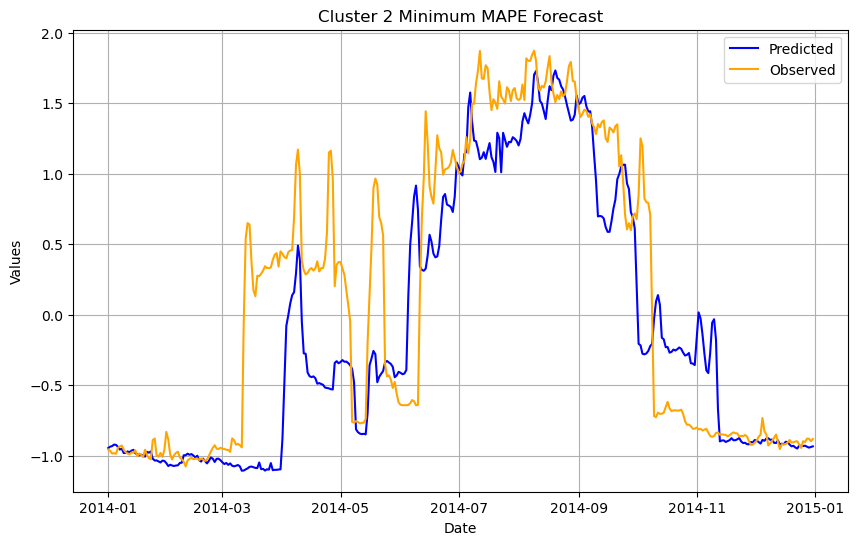

Maximum MAPE for Cluster 2: 59950.6304937678


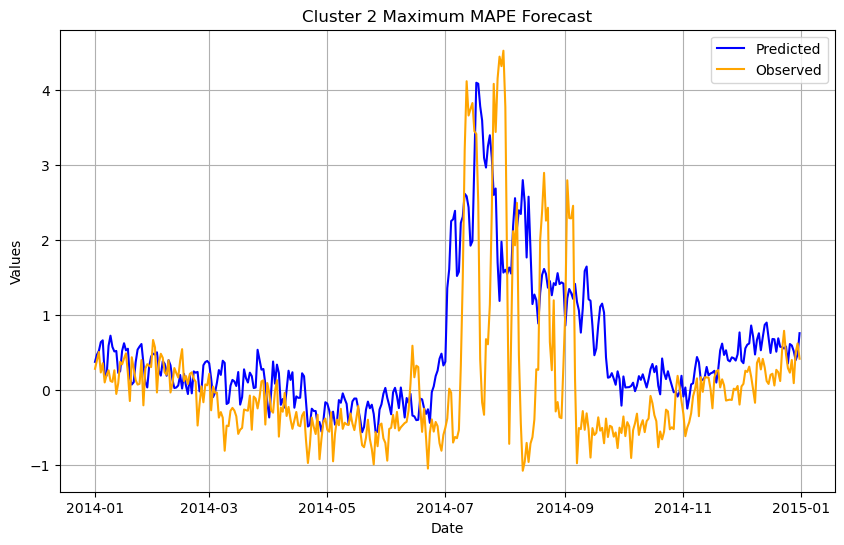

Minimum MAPE for Cluster 3: 127.62916266309172


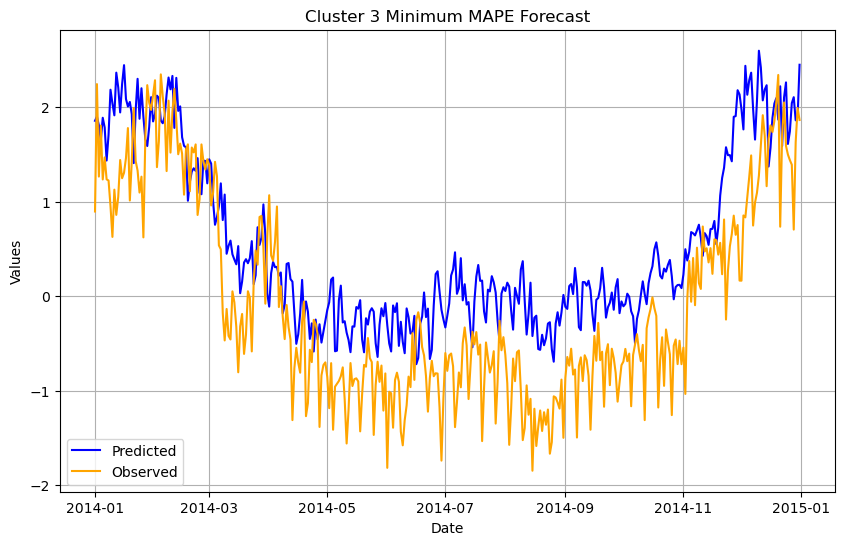

Maximum MAPE for Cluster 3: 2925.550802725564


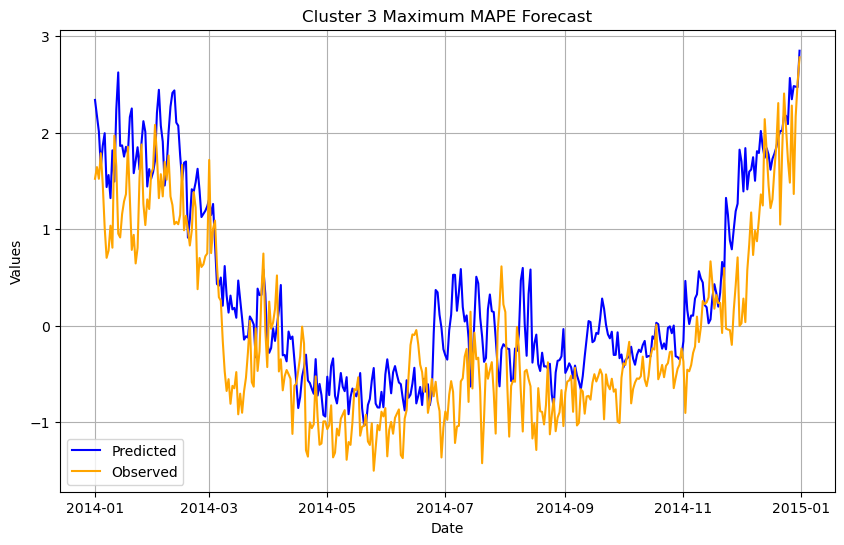

Minimum MAPE for Cluster 4: 271.8332509111872


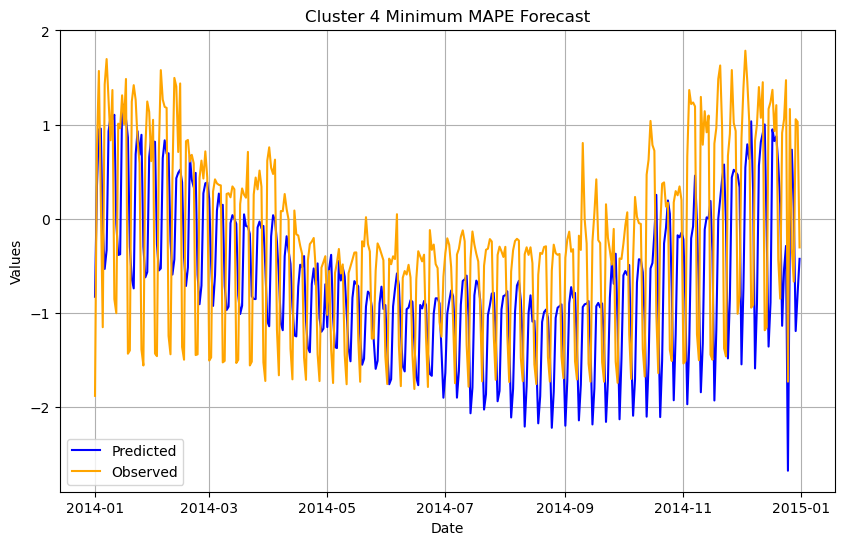

Maximum MAPE for Cluster 4: 3481.715469381757


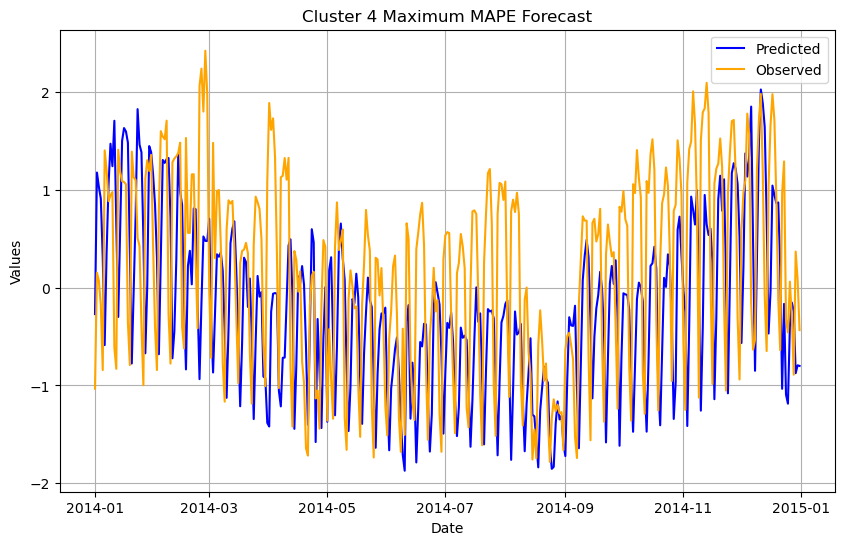

In [15]:
min_mapes = list()
max_mapes = list()

for i in range(len(clustered_customers)):
    min_mape = clustered_customers[i][0]
    max_mape = clustered_customers[i][0]
    for customer in clustered_customers[i]:
        if mape_values[customer] < mape_values[min_mape]:
            min_mape = customer
        if mape_values[customer] > mape_values[max_mape]:
            max_mape = customer

    min_mapes.append(min_mape)
    max_mapes.append(max_mape)

    print(f'Minimum MAPE for Cluster {i+1}: {mape_values[min_mape]}')

    plt.figure(figsize=(10, 6))

    plt.plot(predictions[min_mape]['ds'], predictions[min_mape]['yhat'], label='Predicted', color='blue')

    plt.plot(predictions[min_mape]['ds'], combined_df[customer_df.ds >= cutoff_date][min_mape], label='Observed', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Cluster {i+1} Minimum MAPE Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()


    print(f'Maximum MAPE for Cluster {i+1}: {mape_values[max_mape]}')

    plt.figure(figsize=(10, 6))

    plt.plot(predictions[max_mape]['ds'], predictions[max_mape]['yhat'], label='Predicted', color='blue')

    plt.plot(predictions[max_mape]['ds'], combined_df[customer_df.ds >= cutoff_date][max_mape], label='Observed', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Cluster {i+1} Maximum MAPE Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()